In [1]:
import duckdb, os, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# Configuration and connection
DB_PATH = "D:/db/meta.duckdb"                 

con = duckdb.connect(DB_PATH)

con.execute("PRAGMA threads=2;") 
con.execute("SET memory_limit='5GB';") 
con.execute("SET preserve_insertion_order=false;") 

print("\n Set up ready")


 Set up ready


In [3]:
# Counts by language
lang_df = con.sql("""
SELECT caption_lang, COUNT(*) AS n
FROM caption_lang_1718
GROUP BY caption_lang
ORDER BY n DESC
""").df()

total = lang_df["n"].sum()
lang_df["pct"] = lang_df["n"] / total * 100
lang_df["cum_pct"] = lang_df["pct"].cumsum()

top_k = 10
top10 = lang_df.head(top_k).copy()

display(top10)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,caption_lang,n,pct,cum_pct
0,en,5455700,78.656832,78.656832
1,it,227167,3.275150,81.931982
2,none,198356,2.859771,84.791753
3,es,191961,2.767572,87.559326
4,pt,175956,2.536822,90.096148
5,de,164740,2.375117,92.471265
6,fr,133559,1.925569,94.396834
7,nl,65944,0.950739,95.347573
8,nb,38668,0.557491,95.905064
9,sv,35532,0.512278,96.417342


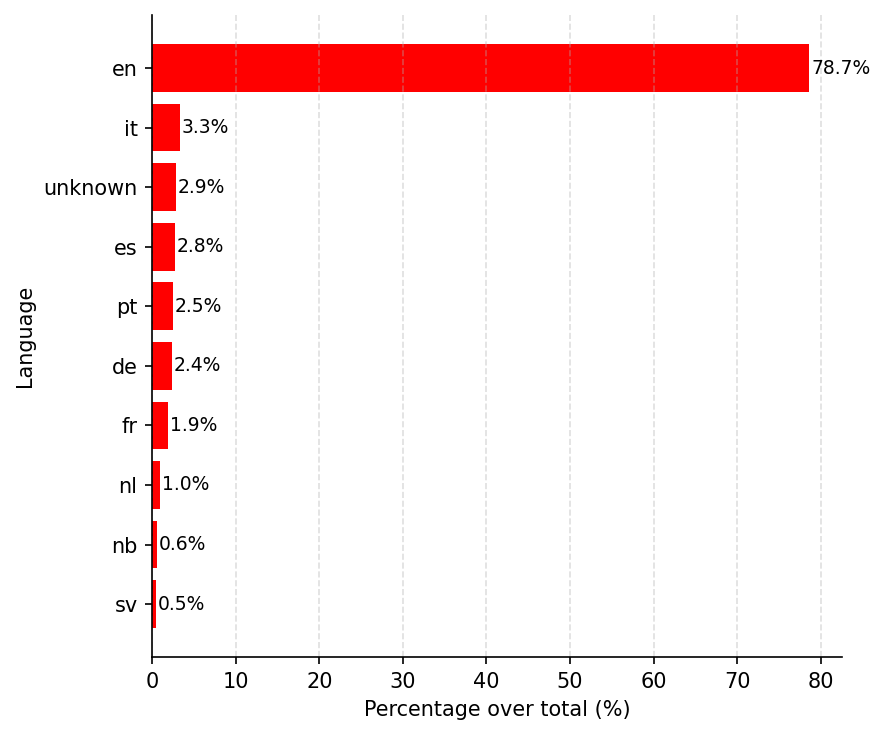

In [4]:
top10_plot = top10.copy()

top10_plot["caption_lang"] = top10_plot["caption_lang"].replace({"none": "unknown"})

top10_plot = top10_plot.sort_values("pct", ascending=True)

plt.figure(figsize=(6, 5), dpi=150)
bars = plt.barh(top10_plot["caption_lang"], top10_plot["pct"], color = 'red')

plt.xlabel("Percentage over total (%)")
plt.ylabel("Language")
plt.grid(axis="x", linestyle="--", alpha=0.4)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for bar in bars:
    w = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(w + 0.2, y, f"{w:.1f}%", va="center", fontsize=9)
plt.savefig("D:/figures/lang_distribution_top10_pct.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

In [14]:
caption_len = con.sql("""SELECT caption_len_char, engagement_rate FROM md1718 """).df()

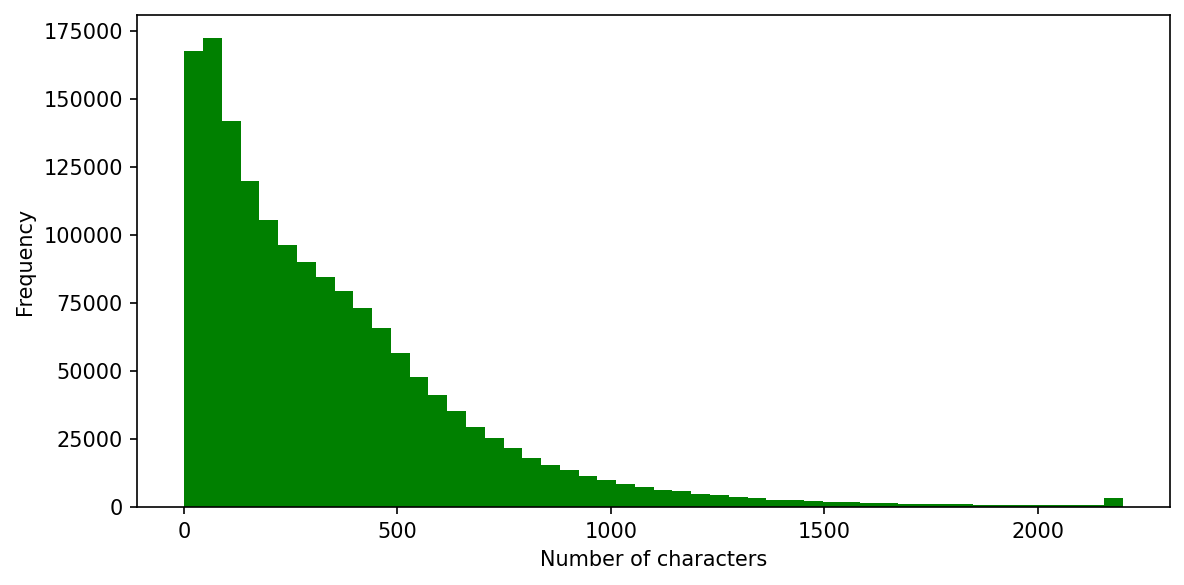

In [20]:
plt.figure(figsize=(8, 4), dpi=150)
plt.hist(caption_len["caption_len_char"], bins=50, color = 'green')
plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("D:/figures/caption_lenghts_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

In [21]:
caption_len["len_bin"] = pd.qcut(
    caption_len["caption_len_char"],
    q=5,
    labels=[
        "Q1",
        "Q2",
        "Q3",
        "Q4",
        "Q5"
    ]
)

In [22]:
bin_stats = (
    caption_len
    .groupby("len_bin")["engagement_rate"]
    .agg(["mean", "median", "std", "count"])
    .reset_index()
)

bin_stats

C:\Users\mimox\AppData\Local\Temp\ipykernel_29788\2913838938.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("len_bin")["engagement_rate"]


,len_bin,mean,median,std,count
0,Q1,4.765700,3.33,5.139021,322327
1,Q2,4.112840,2.84,4.866253,316916
2,Q3,4.073327,2.85,4.914534,318833
3,Q4,4.384674,3.08,6.210822,319475
4,Q5,4.548365,3.20,5.892364,318203


In [24]:
caption = con.sql("""SELECT n_mentions, n_hashtags, n_urls, n_emojis FROM md1718""").df()

In [25]:
struct_stats = {
    "≥1 hashtag": (caption["n_hashtags"] > 0).mean() * 100,
    "≥1 menzione": (caption["n_mentions"] > 0).mean() * 100,
    "≥1 emoji": (caption["n_emojis"] > 0).mean() * 100,
    "≥1 urls": (caption["n_urls"] > 0).mean() * 100
}

struct_df = (
    pd.DataFrame.from_dict(struct_stats, orient="index", columns=["percentage"])
    .reset_index()
    .rename(columns={"index": "feature"})
)

struct_df


,feature,percentage
0,≥1 hashtag,69.899579
1,≥1 menzione,46.521244
2,≥1 emoji,69.033370
3,≥1 urls,4.340554


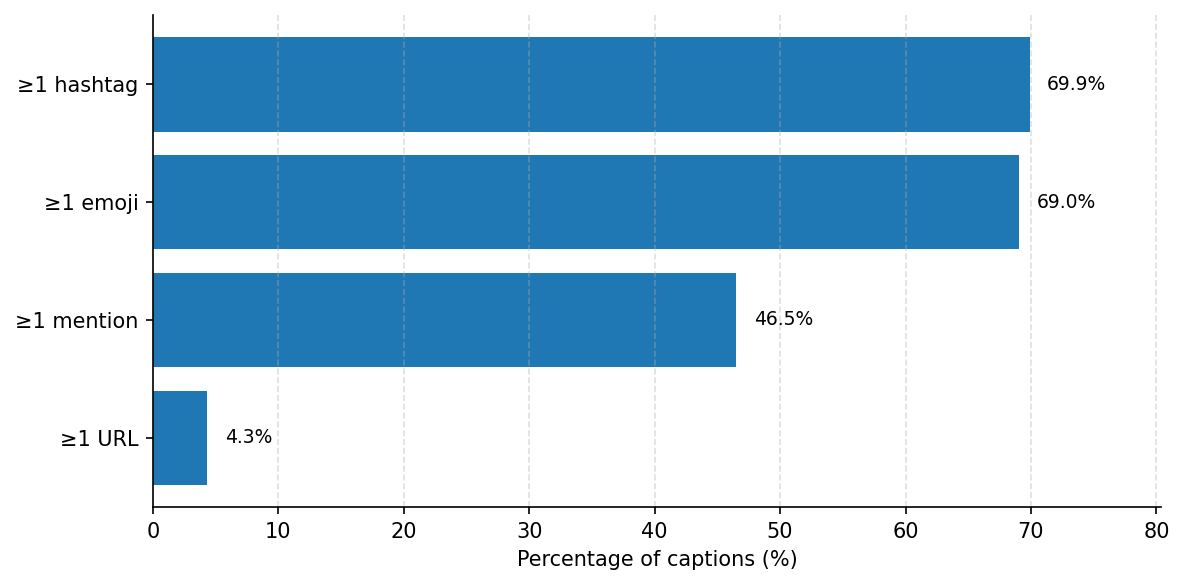

In [33]:
data = {
    "Element": ["≥1 hashtag", "≥1 emoji", "≥1 mention", "≥1 URL"],
    "Percentage": [69.90, 69.03, 46.52, 4.34]
}

df_plot = pd.DataFrame(data)

df_plot = df_plot.sort_values("Percentage", ascending=True)

plt.figure(figsize=(8, 4), dpi=150)
bars = plt.barh(df_plot["Element"], df_plot["Percentage"])

plt.xlabel("Percentage of captions (%)")
plt.grid(axis="x", linestyle="--", alpha=0.4)

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

xmax = df_plot["Percentage"].max()
ax.set_xlim(0, xmax * 1.15)

for bar in bars:
    w = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax.text(
        w + xmax * 0.02,
        y,
        f"{w:.1f}%",
        va="center",
        ha="left",
        fontsize=9
    )

plt.tight_layout()
plt.savefig("D:/figures/percentage_of_elements_captions.png", dpi=300, bbox_inches="tight")
plt.show()

In [20]:
captions = con.sql("""SELECT caption_tfidf, engagement_rate FROM md1718 """).df()
col = "caption_tfidf"

tokens = captions[col].fillna("").astype(str).str.split()
word_freq = Counter([t for toks in tokens for t in toks])

top20 = word_freq.most_common(20)
top20

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[('love', 271075),
 ('one', 214747),
 ('like', 209706),
 ('day', 202400),
 ('get', 188008),
 ('time', 187208),
 ('new', 181190),
 ('christmas', 160568),
 ('today', 151231),
 ('happy', 149485),
 ('know', 125052),
 ('year', 124396),
 ('life', 118632),
 ('see', 117928),
 ('make', 114186),
 ('little', 113510),
 ('good', 112997),
 ('link', 109489),
 ('go', 107634),
 ('much', 100072)]

In [21]:
top20_df = pd.DataFrame(top20, columns=["word", "count"])
top20_df

,word,count
0,love,271075
1,one,214747
2,like,209706
3,day,202400
4,get,188008
5,time,187208
6,new,181190
7,christmas,160568
8,today,151231
9,happy,149485


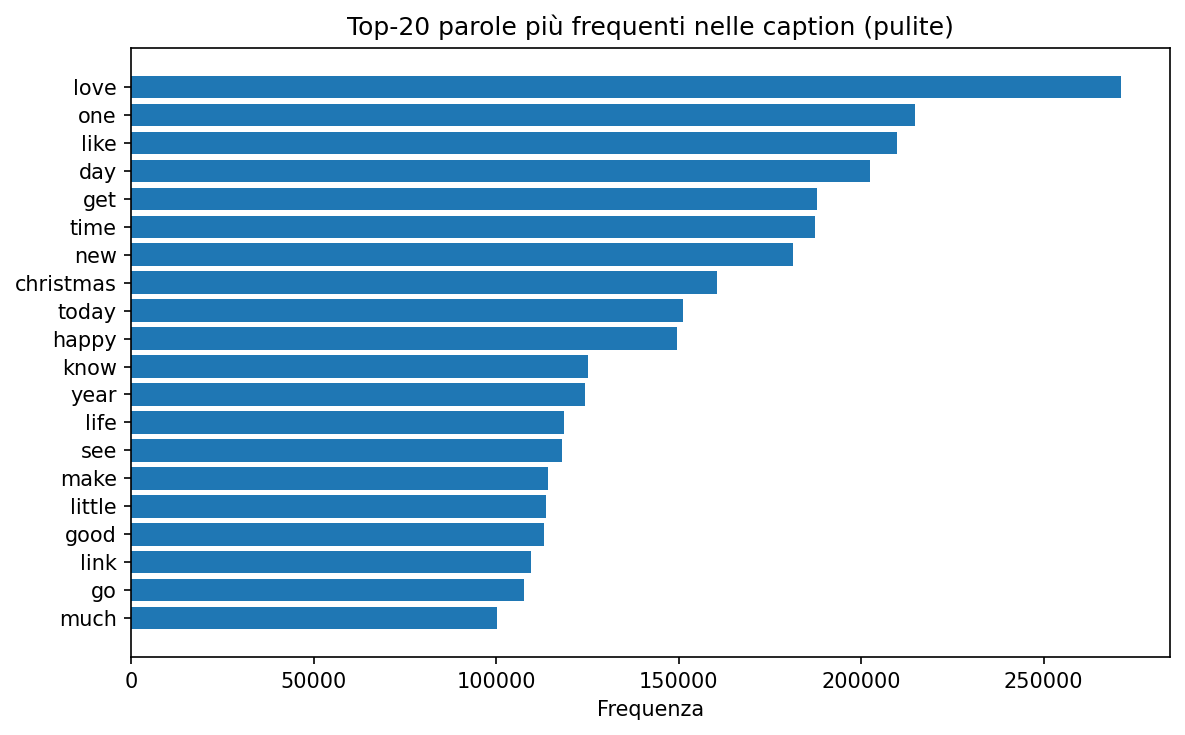

In [22]:
top20_df = pd.DataFrame(word_freq.most_common(20), columns=["word", "count"]).sort_values("count")

plt.figure(figsize=(8,5), dpi=150)
plt.barh(top20_df["word"], top20_df["count"])
plt.xlabel("Frequenza")
plt.title("Top-20 parole più frequenti nelle caption (pulite)")
plt.tight_layout()
plt.show()

In [34]:
hashtags = con.sql("""SELECT caption FROM md1718""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [35]:
col = "caption"

def extract_hashtags(text):
    if not isinstance(text, str):
        return []
    return re.findall(r"#\w+", text.lower())

hashtags["hashtags"] = hashtags[col].apply(extract_hashtags)
all_hashtags = [h for tags in hashtags["hashtags"] for h in tags]


In [36]:
hashtag_freq = Counter(all_hashtags)

top10_hashtags = hashtag_freq.most_common(20)
top10_hashtags

[('#ad', 74282),
 ('#love', 47460),
 ('#ootd', 43358),
 ('#fashion', 40121),
 ('#liketkit', 39096),
 ('#instagood', 36213),
 ('#travel', 29291),
 ('#christmas', 28285),
 ('#style', 26710),
 ('#photooftheday', 26386),
 ('#blogger', 25677),
 ('#sponsored', 24077),
 ('#photography', 24054),
 ('#beauty', 23102),
 ('#makeup', 22931),
 ('#fashionblogger', 22716),
 ('#fitness', 21707),
 ('#foodie', 20203),
 ('#picoftheday', 19235),
 ('#momlife', 17648)]

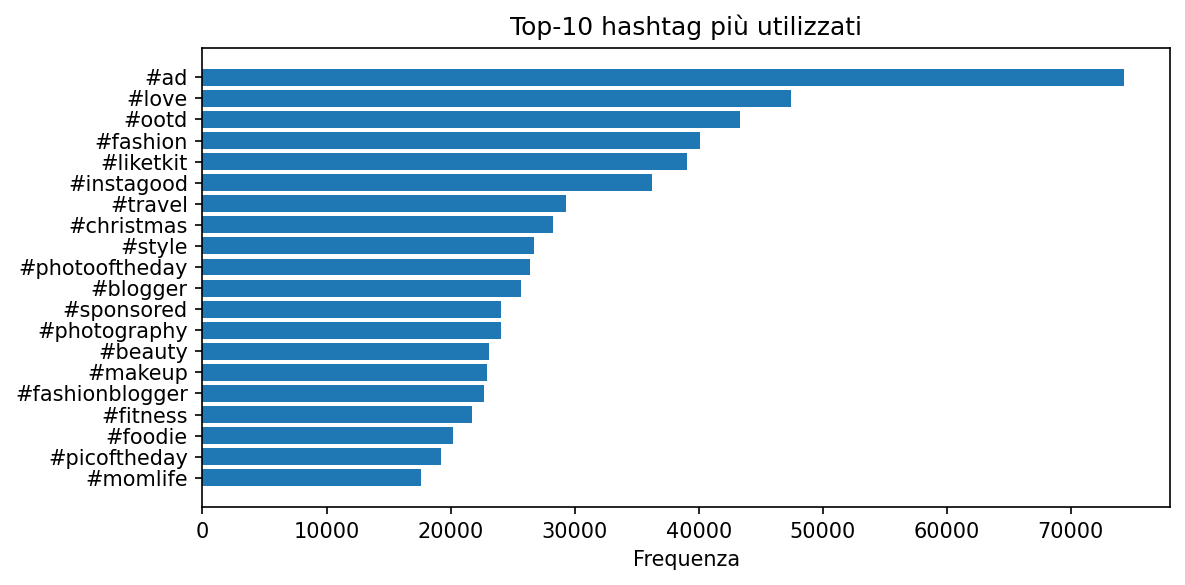

In [37]:
top10_df = pd.DataFrame(top10_hashtags, columns=["hashtag", "count"])
top10_df

top10_df = top10_df.sort_values("count")

plt.figure(figsize=(8, 4), dpi=150)
plt.barh(top10_df["hashtag"], top10_df["count"])
plt.xlabel("Frequenza")
plt.title("Top-10 hashtag più utilizzati")
plt.tight_layout()
plt.show()